This model takes several different currency exchange rates and puts them into the RNN at once as inputs.

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output

In [2]:
def exchangerate_processing(filename):
    """
    Reads in a given file and cleans up all the missing values
    
    Inputs: filename 
    Outputs: exchangevalue
    """
    # Reads in currency exchange rate data
    dataset = pd.read_csv('data/'+filename) # Reads in CSV file
    exchangevalues = dataset.iloc[:, 1:2] # Selects columns

    # Replaces missing data (represented by '.') with zeros ('0')
    mask=exchangevalues=='.'
    exchangevalues[mask] = '0'

    # Reformats columns into floats
    exchangevalues=np.array(exchangevalues)
    exchangevalues=np.matrix([float(x) for x in exchangevalues])
    exchangevalues=exchangevalues.transpose()

    # Fills in missing and outlier values by taking average between adjacent timesteps
    mean,std=np.mean(exchangevalues),np.std(exchangevalues) # Computes mean and std
    indices = [i for i ,x in enumerate(exchangevalues) if x<mean-2.5*std] # Finds indices of zero and outlier values
    for i in indices:
        # First, checks the initial and final elements of the list
        # If any of these are zero, set them to be equal to their adjacent values
        if i==0:
            exchangevalues[i] = exchangevalues[i+1]
        elif i==len(exchangevalues)-1:
            exchangevalues[i] = exchangevalues[i-1]

        # For the rest of the elements, set them to be the average of their adjacent values
        exchangevalues[i] = 0.5*(exchangevalues[i+1]+exchangevalues[i-1]) 
    
    return exchangevalues

In [10]:
# Reads in all the files
#input_files=['DEXCAUS.csv', 'DEXJPUS.csv', 'DEXMXUS.csv',\
#             'DEXUSUK.csv', 'DEXCHUS.csv', 'DEXKOUS.csv',\
#             'DEXUSEU.csv']

input_files=['DEXUSUK.csv', 'DEXUSEU.csv','DEXCHUS.csv']

# Contructs the training set
training_set=np.array([exchangerate_processing(x) for x in input_files])
training_set = np.reshape(training_set, (training_set.shape[0], training_set.shape[1]))
training_set = training_set.T
print(training_set.shape)  

/home/ansonl/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ansonl/.local/lib/python3.5/site-packages/pandas/core/frame.py:3163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


(2610, 3)


In [11]:
# Train/test set parameters
N_timesteps = 60 # Number of timesteps in each training epoch
N_total_timesteps = training_set.shape[0] # The total number of timesteps in the dataset
N_test_timesteps = int(0.15*N_total_timesteps) # Number of timesteps for the test set

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled shape',training_set_scaled.shape)

# Creates a data structure with N timesteps and 1 output
X_train ,y_train = [], []
for i in range(N_timesteps, N_total_timesteps-N_test_timesteps):
    X_train.append(training_set_scaled[i-N_timesteps:i,:])
    y_train.append(training_set_scaled[i,:])
X_train, y_train = np.array(X_train), np.array(y_train)
print('X_train shape',X_train.shape)
print('y_train shape',y_train.shape)

X_test, y_test = [], []
for i in range(N_total_timesteps-N_test_timesteps, len(training_set)):
    X_test.append(training_set_scaled[i-N_timesteps:i,:])
    y_test.append(training_set_scaled[i,:])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshaping
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#y_train = np.reshape(y_train, (y_train.shape[0], 1))
#y_test = np.reshape(y_test, (y_test.shape[0], 1))

print('X_test shape',X_test.shape)
print('y_test shape',y_test.shape)

training_set_scaled shape (2610, 3)
X_train shape (2159, 60, 3)
y_train shape (2159, 3)
X_test shape (391, 60, 3)
y_test shape (391, 3)


**Parameter tuning the RNN**

- Increase the number of timesteps. Note that this also tends to increase the phase delay of the prediction.
- Adding more LSTM layers
- Adding more neurons to the LSTM layers
- For parameter tuning, use scoring = 'neg_mean_squared_error'

In [12]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Define network parameters
hidden_units=50
dropout_rate=0.2

regressor.add(LSTM(units = hidden_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout_rate))

#regressor.add(LSTM(units = hidden_units, return_sequences = True))
#regressor.add(Dropout(dropout_rate))

regressor.add(LSTM(units = hidden_units, return_sequences = True))
regressor.add(Dropout(dropout_rate))

regressor.add(LSTM(units = hidden_units))
regressor.add(Dropout(dropout_rate))

regressor.add(Dense(units = X_train.shape[2]))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [13]:
# RNN architecture details
regressor.summary()

# A class for live plotting the losses as the RNN is trained
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, np.log10(self.losses),'k-', label="loss")
        plt.plot(self.x, np.log10(self.val_losses), 'g-', label="val_loss")
        plt.legend()
        plt.ylabel('log(Loss)')
        plt.xlabel('Epoch')
        plt.grid(True)

        plt.show();
        
plot_losses = PlotLosses()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            10800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total para

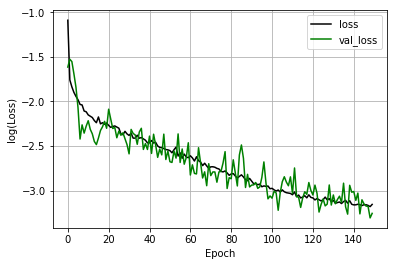

In [14]:
# Fit the RNN to the Training set
history=regressor.fit(X_train, y_train, validation_split=0.2, epochs = 150, \
                      batch_size = 32, callbacks=[plot_losses])

In [15]:
# Makes preductions using the test set and the trained RNN model
predicted_values = regressor.predict(X_test)

# Inverts feature scaling transformation
y_train = sc.inverse_transform(y_train)
y_test = sc.inverse_transform(y_test)
predicted_values = sc.inverse_transform(predicted_values)

print(y_train.shape,y_test.shape,predicted_values.shape)

(2159, 3) (391, 3) (391, 3)


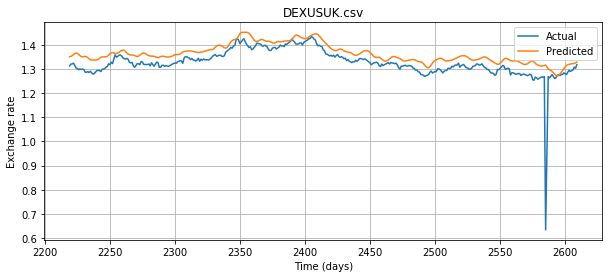

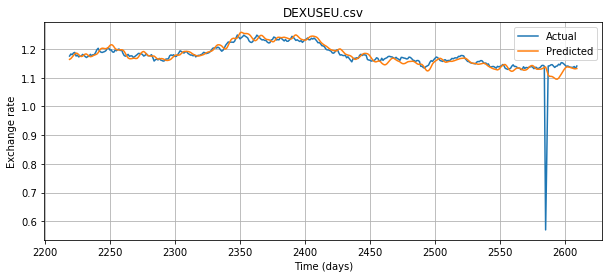

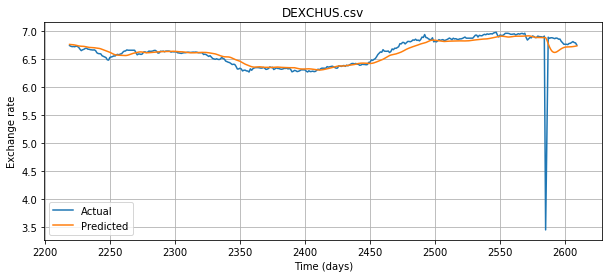

In [16]:
# Does plotting


#plt.plot(range(N_timesteps, len(training_set)-N_test_timesteps),y_train,label = 'Training data')
x_predicted=np.array(range(N_total_timesteps-N_test_timesteps, N_total_timesteps))

# Loops over all the different currencies
for i,x in enumerate(input_files):
    plt.figure(figsize=(10,4))
    plt.plot(x_predicted,y_test[:,i],label = 'Actual')
    plt.plot(x_predicted,predicted_values[:,i],label = 'Predicted')
    plt.title(x)
    plt.xlabel('Time (days)')
    plt.ylabel('Exchange rate')
    plt.legend()
    plt.grid(True)
    plt.show() 